In [1]:
from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from src.autobounds_tools import *
import pandas as pd
from src.test_statistics import chi_square_from_df,difference_in_proba_from_df
from autobound.Query import Query
import numpy as np
import itertools
import torch
from io import StringIO
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from functools import reduce
from pyomo.opt import SolverStatus, TerminationCondition
import io 
from copy import deepcopy
from multiprocessing import Process,Pool
import time
import sys
from autobound.Program import pyomo_symb,mult_params_pyomo,parse_bounds,solve1
import matplotlib.pyplot as plot
from sklearn.linear_model import LogisticRegression
from src.utils import return_prob_df, train_fairness_classifiers,return_prob_df_unselected,calc_disparity_metric

In [2]:
def get_causal_fairness_metrics(problem,query):

    if query == "TE":
        return (problem.query('Q(A=1)=1') + problem.query('Q(A=0)=1', -1),Query(1)
)
    if query == "CF":
        return (problem.query('Q(A=1)=1&Q(A=0)=1') + problem.query('Q(A=1)=0&Q(A=0)=0'),Query(1))
    
    if query == "SE":
        return (problem.query('Q(A=1)=1')*problem.query('A=1') + problem.query('Q=1&A=0',-1),problem.query())

def get_causal_constraint(problem,query,val):

    if query == "TE":
        return (problem.query('Q(A=1)=1&S=1') + problem.query('Q(A=0)=1&S=1', -1) + Query(val)*problem.query('S=1', -1)
)
    if query == "CF":
        return problem.query('Q(A=1)=1&Q(A=0)=1&S=1') + problem.query('Q(A=1)=0&Q(A=0)=0&S=1') + Query(val)*problem.query('S=1', -1)
    
    if query == "SE":
        return problem.query('Q(A=1)=1&S=1')*problem.query('A=1&S=1') + problem.query('Q=1&A=0&S=1',-1) + Query(val)*problem.query('S=1', -1)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
sns.set_theme()
sns.set_style("whitegrid")

In [4]:
ds = np.load("/Users/jake/Python/Testing_fairness/data/dutch.abroca.npz")
X, y, A = ds["X"], ds["y"], ds["A"]
perm = np.random.choice(y.shape[0], size=(y.shape[0],), replace=False)
prop = int(0.5 * y.shape[0])

X_train, y_train, A_train = X[perm][:-prop], y[perm][:-prop], A[perm][:-prop]
X_test, y_test, A_test = X[perm][-prop:], y[perm][-prop:], A[perm][-prop:]

In [5]:
classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric="DP")
prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

In [6]:
prob_df

,A,Z,P,prob
0,0,0,0,0.253889
1,0,0,1,0.087090
2,0,1,0,0.025753
3,0,1,1,0.135386
4,1,0,0,0.166600
5,1,0,1,0.021119
6,1,1,0,0.103509
7,1,1,1,0.206653


In [41]:

# missingness_prob = 0.05

def run_causal_fairness(prob_df,CF_metric,missingness_prob):
    if "Z" in prob_df.columns:
        prob_df["Y"] = prob_df["Z"]
        prob_df = prob_df.drop("Z",axis=1)

    if "P" in prob_df.columns:
        prob_df["Q"] = prob_df["P"]
        prob_df = prob_df.drop("P",axis=1)

    selec_prob_df = prob_df.copy()
    selec_prob_df["S"] = 1 
    selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]

    dag = DAG()
    dag.from_structure("A->Y, A->Q, A->Y, U->Q, U->Y, U->S, Y->S" ,unob="U")
    # dag.from_structure("A -> S, A -> Y,A -> Q, U->Q, U->Y" ,unob="U")


    problem = causalProblem(dag)

    numerator,denominator = get_causal_fairness_metrics(problem,CF_metric)

    if CF_metric == "CF":
        constraint = get_causal_constraint(problem,"CF",0.1)
        problem.add_constraint(constraint=constraint,symbol="==")
    # problem.add_constraint(constraint=Query(-1)*constraint,symbol="<=")
    problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))

    problem.add_prob_constraints()

    problem.set_estimand(numerator)
    # problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))

    program = problem.write_program()
    try:
        result = program.run_pyomo('ipopt',verbose=False)
    except:
        result = (None,None,True,True)
    return result

In [42]:
run_causal_fairness(prob_df,"CF",0.01)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

(0.09899989011767749, 0.10900010988213372, True, True)

In [39]:
run_causal_fairness(prob_df,"CF",0.2)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

(0.03999990757873038, 0.20324438722412388, True, True)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

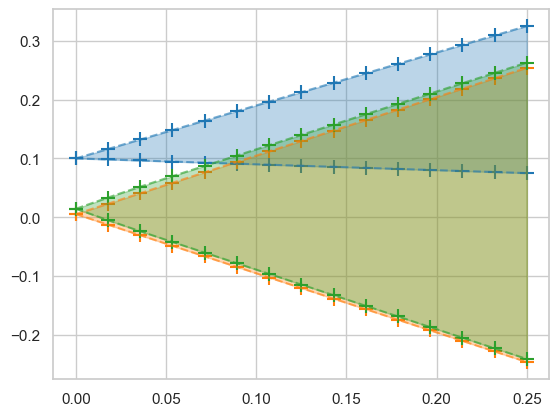

In [49]:
metrics = ["CF","SE","TE"]
colours = sns.color_palette("tab10", 3)

fig, ax = plt.subplots(nrows=1,ncols=1,sharey=True,figsize= (25.6/4,4.8 ))

range_curve = np.linspace(0,0.1,200)
range_ab = np.linspace(0,0.25,15)
for i,metric in enumerate(metrics):
# i=1
    lower_results = []
    upper_results = []
    for val in range_ab:
        sens_results = run_causal_fairness(prob_df,metric,val)
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])
    ax.fill_between(range_ab, lower_results, upper_results, alpha=.3,color = colours[i])
    ax.plot(range_ab, upper_results, ls='--', alpha=.6,color=colours[i])
    ax.plot(range_ab, lower_results, ls='--', alpha=.6,color=colours[i])
    ax.scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
    ax.scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
    # lower_results = []
    # upper_results = []

    # for val in range_ab:
    #     sens_results = autobounds_prox_sens_fogliatio(prob_df,alpha = val,group=0,disparity_metric = metric)
    #     lower_results.append(sens_results[0])
    #     upper_results.append(sens_results[1])

    # ax[0].scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
    # ax[0].scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])

In [50]:
legend_elements = [
                   Patch(facecolor=colours[0],
                         label='Color Patch'),
                     Patch(facecolor=colours[1],
                         label='Color Patch'),
                     Patch(facecolor=colours[2],
                         label='Color Patch'),
                      ]
legend_titles = metrics 
leg = ax.legend(legend_elements,legend_titles,loc="upper left",ncol=2,fontsize ="10")

In [53]:
ax.set_title("Causal Fairness Metrics Under Selection On Adult Dataset")

Text(0.5, 1.0, 'Causal Fairness Metrics Under Selection On Adult Dataset')

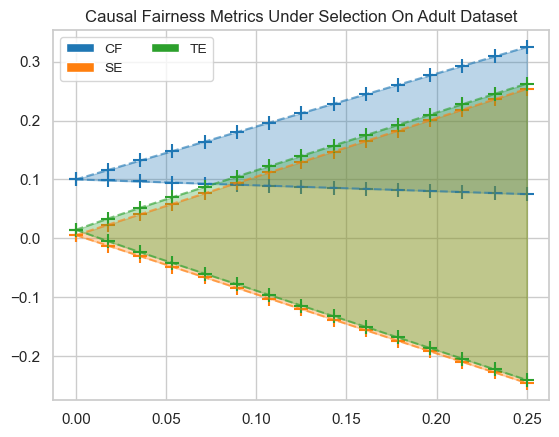

In [54]:
fig

In [59]:
ax.set_xlabel(r"$P(S=0)$")
ax.set_ylabel("Metric Value")

Text(4.444444444444452, 0.5, 'Metric Value')

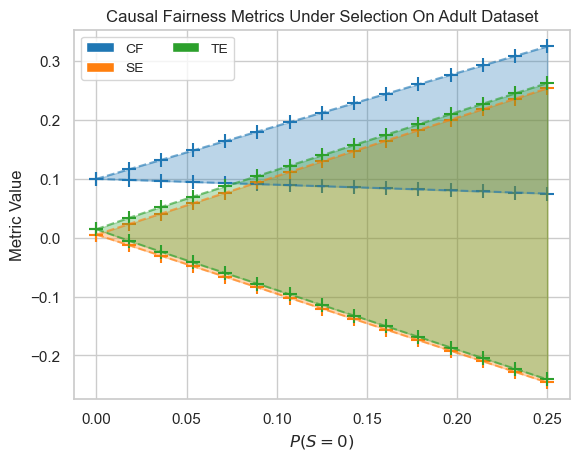

In [60]:
fig

In [8]:
result

(0.04920956652063262, 0.04920956652063249, False, False)

In [9]:
LR_classifier.fit(X_train,y_train)

NameError: name 'LR_classifier' is not defined

(array([4211., 4245., 2175., 1419., 1562., 1757., 2418., 3705., 3818.,
        4900.]),
 array([0.00160644, 0.10132374, 0.20104103, 0.30075833, 0.40047562,
        0.50019292, 0.59991021, 0.69962751, 0.7993448 , 0.8990621 ,
        0.99877939]),
 <BarContainer object of 10 artists>)

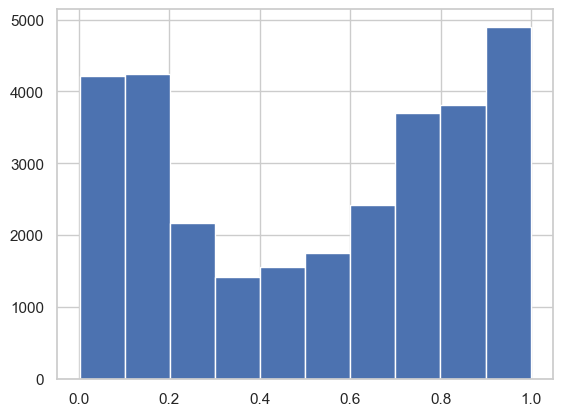

In [ ]:
plot.hist(LR_classifier.predict_proba(X_train)[:,0])

In [ ]:
def selective_labels(selective_prop,disparity_metric):

    truth_vec_train = (LR_classifier.predict_proba(X_train)[:,1]>selective_prop)
    truth_vec_test = (LR_classifier.predict_proba(X_train)[:,1]>selective_prop)

    X_train_subset,y_train_subset,A_train_subset = X_train[truth_vec_train], y_train[truth_vec_train],A_train[truth_vec_train] 
    X_test_subset,y_test_subset,A_test_subset = X_test[truth_vec_test], y_test[truth_vec_test],A_test[truth_vec_test] 

    classifiers = train_fairness_classifiers(X_train_subset,y_train_subset,A_train_subset,disparity_metric=disparity_metric)
    pred_df = return_prob_df(classifiers[0],X_test_subset,y_test_subset,A_test_subset)
    pred_df["S"] = 1
    pred_df["Y"] = pred_df["Z"]
    prob_df = pred_df.drop("Z",axis=1)

    unselect_pred_df = return_prob_df_unselected(classifiers[0],X_test,y_test,A_test,truth_vec_test)
    dag = DAG()        
    dag.from_structure("A -> S, A -> Y,A -> P, U->P,V->P, V->S,Y->S, U->Y " ,unob="U,V")
    # dag.from_structure("A -> S, A -> Y,A -> P, V->S,Y->S, U->Y " ,unob="U,V")
    problem = causalProblem(dag)
    problem.load_data(StringIO(pred_df.to_csv(index=False)),cond=["S"])
    problem.load_data(StringIO(unselect_pred_df.to_csv(index=False)))
    numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")
    problem.add_prob_constraints()
    problem.set_estimand(numerator,div=denominator)
    program = problem.write_program()
    result = program.run_pyomo(verbose=False)
    metric_val = calc_disparity_metric(y_test_subset,classifiers[0].predict(X_test_subset),A_test_subset,disparity_metric=disparity_metric)
    return result, metric_val ,classifiers[0]

In [ ]:
selective_prop = 0.05
disparity_metric = "FPR"

truth_vec_train = (LR_classifier.predict_proba(X_train)[:,1]>selective_prop)
truth_vec_test = (LR_classifier.predict_proba(X_train)[:,1]>selective_prop)

X_train_subset,y_train_subset,A_train_subset = X_train[truth_vec_train], y_train[truth_vec_train],A_train[truth_vec_train] 
X_test_subset,y_test_subset,A_test_subset = X_test[truth_vec_test], y_test[truth_vec_test],A_test[truth_vec_test] 

classifiers = train_fairness_classifiers(X_train_subset,y_train_subset,A_train_subset,disparity_metric=disparity_metric)
pred_df = return_prob_df(classifiers[0],X_test_subset,y_test_subset,A_test_subset)
pred_df["S"] = 1
pred_df["Y"] = pred_df["Z"]
prob_df = pred_df.drop("Z",axis=1)

unselect_pred_df = return_prob_df_unselected(classifiers[0],X_test,y_test,A_test,truth_vec_test)
dag = DAG()        
dag.from_structure("A -> S, A -> Y,A -> P, U->P,V->P, V->S,Y->S, U->Y " ,unob="U,V")
problem = causalProblem(dag)
problem.load_data(StringIO(pred_df.to_csv(index=False)),cond=["S"])
problem.load_data(StringIO(unselect_pred_df.to_csv(index=False)))
numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")
problem.add_prob_constraints()
problem.set_estimand(numerator,div=denominator)
program = problem.write_program()

# M = pyo.ConcreteModel()
# solver = pyo.SolverFactory('couenne')
# for p in program.parameters:
#     if p != 'objvar':
#         setattr(M, p, pyo.Var(bounds = (0,1)))
#     else:
#         setattr(M, p, pyo.Var())
# # Next loop is not elegant, needs refactoring
# for i, c in enumerate(program.constraints):
#     setattr(M, 'c' + str(i),
#             pyo.Constraint(expr = 
#                 pyomo_symb[c[-1][0]](sum([ mult_params_pyomo(program.parameters, k, M ) for k in c[:-1] ]), 0)
#             )
#     )
# program.M_upper = deepcopy(M)
# program.M_lower = deepcopy(M)
# program.M_upper.obj = pyo.Objective(expr = program.M_upper.objvar, sense = pyo.maximize)
# program.M_lower.obj = pyo.Objective(expr = program.M_lower.objvar, sense = pyo.minimize)
# solve1(solver,program.M_lower,'lower',True)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

KeyboardInterrupt: 

In [ ]:
selective_labels(0.0,"PPP")

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

((-0.008126167265500788, -0.008126167265689665, True, True),
 -0.008125963793293306,
 LogisticRegression())

In [ ]:
metrics = ["FPR","FNR","PPP","NPP"] 
selective_prop = 0.2
results_dict = {}
true_val = {}

for metric in metrics:
    results_dict[metric] = selective_labels(selective_prop,metric)
    true_val[metric] = calc_disparity_metric(y_test,results_dict[metric][2].predict(X_test), A_test, disparity_metric=metric)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

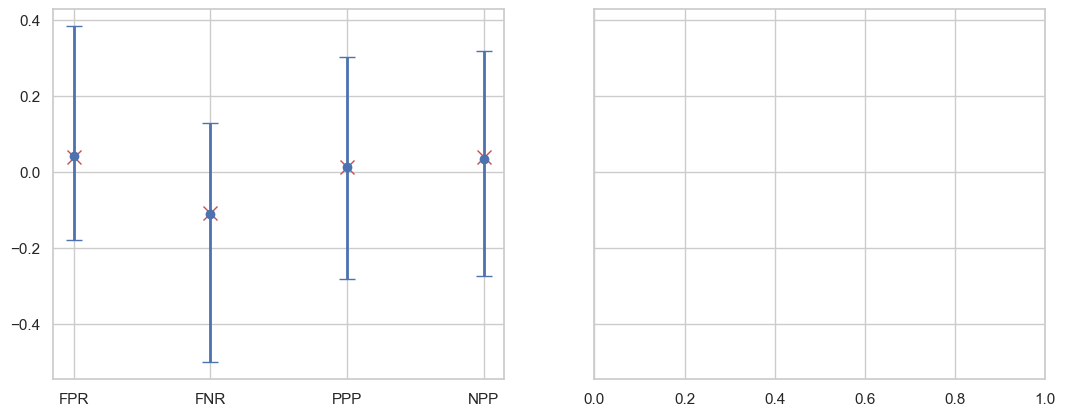

In [ ]:
colours = sns.color_palette("tab10", 4)
fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize= (25.6/2,4.8 ))

ax[0].errorbar(metrics,[results_dict[x][1] for x in metrics],[[results_dict[x][1] - results_dict[x][0][0] for x in metrics],[results_dict[x][0][1]-results_dict[x][1] for x in metrics]],fmt='o', linewidth=2, capsize=6)
for i,metric in enumerate(metrics):
    ax[0].plot(i,true_val[metric],"rx", markersize=10)

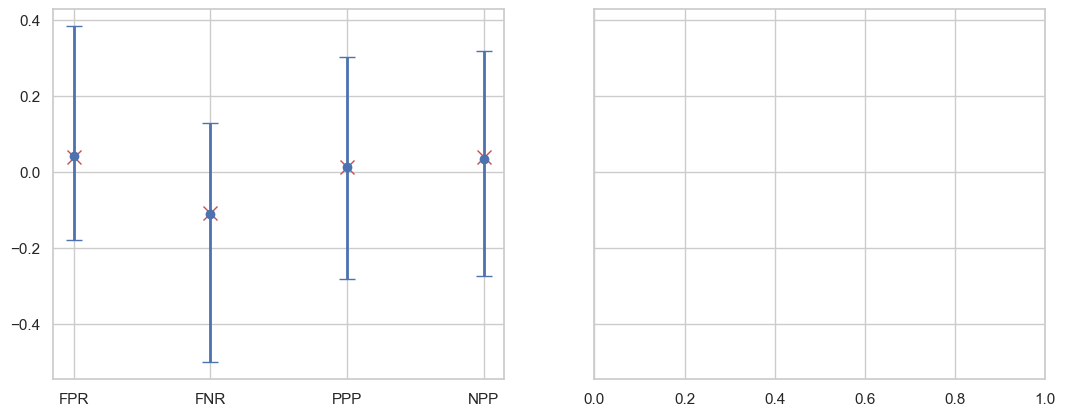

In [ ]:
fig

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
[[results_dict[x][1] - results_dict[x][0][0] for x in metrics],[results_dict[x][0][1]-results_dict[x][1] for x in metrics]]

[[0.2556832543218333,
  0.42356510627178046,
  0.31094884583539184,
  0.34073095411320464],
 [0.33845620629756756,
  0.2722770788464227,
  0.328234590813531,
  0.2946342058670025]]

In [ ]:
results_dict

{'FPR': ((-0.10120886469544597, 0.4929305959239549, True, True),
  0.15447438962638732),
 'FNR': ((-0.5105597156764758, 0.18528246944172727, True, True),
  -0.08699460940469542),
 'PPP': ((-0.3178041984686204, 0.3213792381803024, True, True),
  -0.00685535263322859),
 'NPP': ((-0.26481892919192135, 0.3705462307882858, True, True),
  0.0759120249212833)}

In [ ]:
result_list = [ ]
range_ab = np.linspace(0,0.1,6)
for val in range_ab:
    csv_string = "autobounds_data/trained_models/proxy_adult/FNR.csv"
    metric = "FPR"
    missingness_prob=val
    proxy_nequal =val
    additional_edge=True
    comparison="diff"

    prob_df = pd.read_csv(csv_string)


    # if "Z" in prob_df.columns:
    #     prob_df["Y"] = prob_df["Z"]
    #     prob_df = prob_df.drop("Z",axis=1)

    selec_prob_df = prob_df.copy()
    selec_prob_df["S"] = 1 
    selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]
    dag = DAG()
    dag.from_structure("A -> Y, A->P, U->P, U -> Y, V->P, V -> Z,A->Z,A->S,Y->S,W->S,W->P,Q->Z,Q->S", unob = "U,V,W,Q")
    problem = causalProblem(dag)

    numerator,denominator = get_numerator_denominator(problem,metric,comparison)

    problem.add_prob_constraints()
    problem.set_estimand(numerator,div=denominator)
    problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
    program = problem.write_program()
    result = program.run_pyomo('ipopt',verbose=False)
    result_list.append(result)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

In [ ]:
result_list_select = []
for val in range_ab:
    missingness_prob = val
    prob_df = pd.read_csv(csv_string)
    if "Z" in prob_df.columns:
        prob_df["Y"] = prob_df["Z"]
        prob_df = prob_df.drop("Z",axis=1)

    selec_prob_df = prob_df.copy()
    selec_prob_df["S"] = 1 
    selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]

    dag = DAG()
    dag.from_structure("A -> S, A -> Y,A -> P, Y->S, U->Y, U->P,V->P, V->S " ,unob="U,V")

    problem = causalProblem(dag)

    numerator,denominator = get_numerator_denominator(problem,metric,comparison)

    problem.add_prob_constraints()
    problem.add_constraint(problem.query("S=0&Y=0")-problem.query("S=0&Y=1"),symbol=">=")
    problem.set_estimand(numerator,div=denominator)
    problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
    program = problem.write_program()
    result = program.run_pyomo('ipopt',verbose=False)
    result_list_select.append(result)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

In [ ]:
result_list_prox = []
for val in range_ab:
    proxy_nequal = val
    prob_df = pd.read_csv(csv_string)
    dag = DAG()
    # dag.from_structure("A -> Y, A->P, Y -> Z,P->Z")
    dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y, V->P, V -> Z,A->Z", unob = "U,V")
    problem = causalProblem(dag)
    problem.load_data('autobounds_data/trained_models/proxy_adult/FNR.csv')
    numerator,denominator = get_numerator_denominator(problem,metric,comparison)
    problem.set_estimand(numerator,div=denominator)
    problem.add_prob_constraints()
    problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
    program = problem.write_program()
    result = program.run_pyomo('ipopt',verbose=False)
    result_list_prox.append(result)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

In [ ]:
proxy_nequal = 0
prob_df = pd.read_csv(csv_string)
dag = DAG()
# dag.from_structure("A -> Y, A->P, Y -> Z,P->Z")
dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y, V->P, V -> Z", unob = "U,V")
problem = causalProblem(dag)
problem.load_data('autobounds_data/trained_models/proxy_adult/FNR.csv')
numerator,denominator = get_numerator_denominator(problem,metric,comparison)
problem.set_estimand(numerator,div=denominator)
problem.add_prob_constraints()
problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
program = problem.write_program()
result = program.run_pyomo('ipopt',verbose=False)
r0_list = [result]

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

In [ ]:
len(results[3])

NameError: name 'results' is not defined

In [ ]:
results[0]

[(0.0015530737925855097, 0.001553073793751956, True, True),
 (0.0015202648841324965, 0.0015784710642034717, True, True),
 (-0.11418774026767899, 0.09199788509446977, True, True),
 (-0.18437237811601095, 0.16328272479727007, True, True),
 (-0.253465380899639, 0.2233125496385655, True, True),
 (-0.32556242746364356, 0.26325761876227666, True, True),
 (-0.4008637872344781, 0.3049780253171756, True, True)]

In [ ]:
result_list_plus = [(x[0]+y[0],x[1]+y[1]) for x,y in zip(result_list_prox,result_list_select)]

In [ ]:
legend_labels = ["Proxy and Selection combined","Proxy","Selection"]

Text(0, 0.5, 'Metric Value')

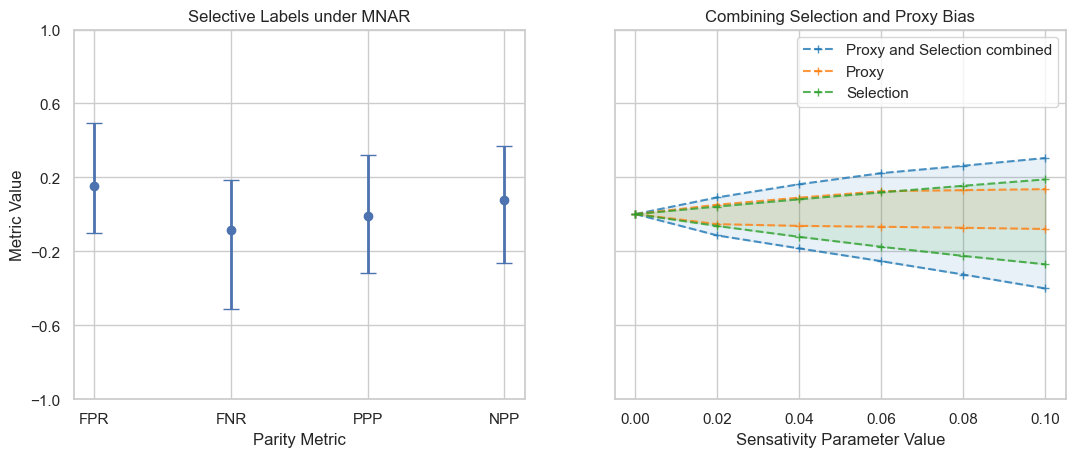

In [ ]:
colours = sns.color_palette("tab10", 4)
fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize= (25.6/2,4.8 ))

ax[0].errorbar(metrics,[results_dict[x][1] for x in metrics],[[results_dict[x][1] - results_dict[x][0][0] for x in metrics],[results_dict[x][0][1]-results_dict[x][1] for x in metrics]],fmt='o', linewidth=2, capsize=6)

range_ab = np.linspace(0,0.1,6)
results = [result_list[1:],result_list_prox[1:],result_list_select[1:]]
results = [r0_list+rl for rl in results]

lines = []

for i,r_list in enumerate(results):
    lower_results = []
    upper_results = []
    for val in r_list:
        lower_results.append(val[0])
        upper_results.append(val[1])
    ax[1].fill_between(range_ab, lower_results, upper_results, alpha=.1,color = colours[i])
    line,  = ax[1].plot(range_ab, upper_results, ls='--', marker='+', alpha=0.8,color=colours[i])
    ax[1].plot(range_ab, lower_results, ls='--',marker='+', alpha=0.8,color=colours[i])
    lines.append(line)

ax[0].set_title("Selective Labels under MNAR")
ax[1].set_title("Combining Selection and Proxy Bias")
ax[1].legend(handles = lines,labels = legend_labels)
ax[1].set_yticks(np.arange(-1, 1.2, 0.4))
ax[0].set_xlabel("Parity Metric")
ax[1].set_xlabel("Sensativity Parameter Value")
ax[0].set_ylabel("Metric Value")


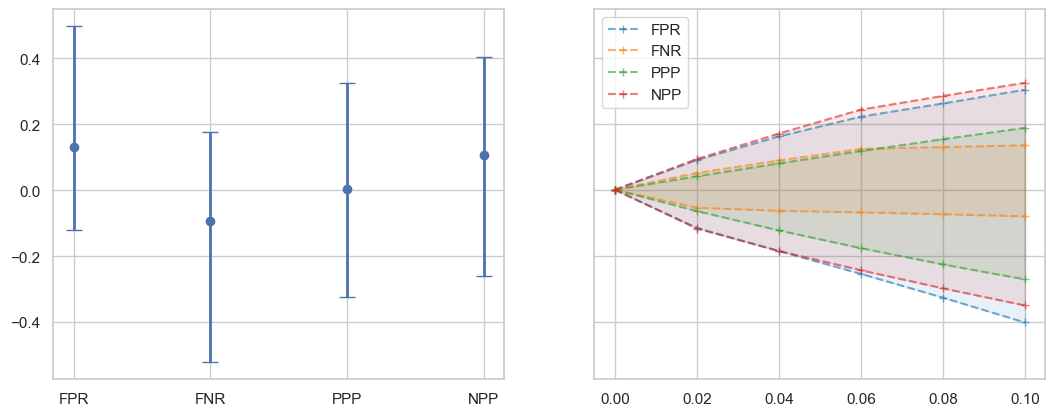

In [ ]:
fig

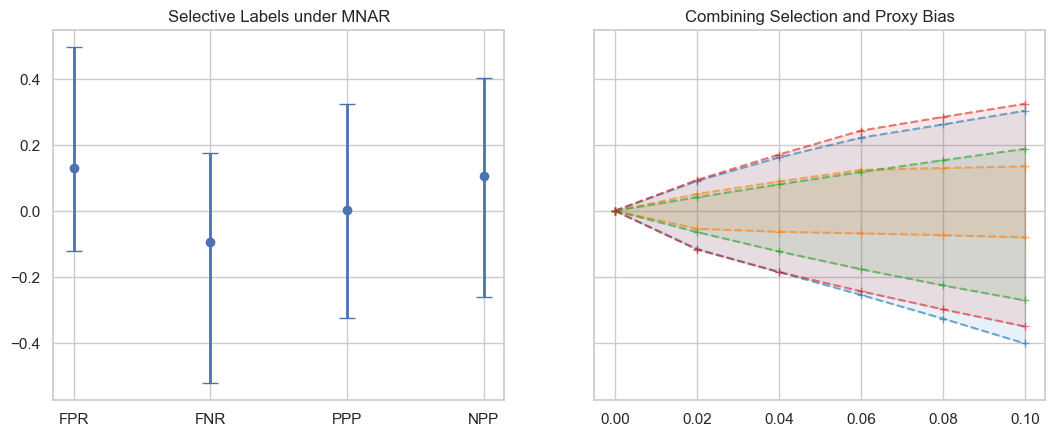

In [ ]:
fig

In [ ]:
dag = DAG()
dag.from_structure("A -> Y, A -> P, A -> S, Y -> P, Y -> S, U -> S,U -> P",unob="U")
problem = causalProblem(dag)
problem.load_data('autobounds_data/selected_data.csv',cond=["S"])
problem.load_data('autobounds_data/unselected_data.csv')
numerator,denominator = get_numerator_denominator(problem,metric,comparison)
problem.set_estimand( problem.query("P=0"))
problem.add_prob_constraints()
program = problem.write_program()
program.run_pyomo()

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query_cond = [ f'{row_cond.index[j]}={int(row_cond[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

Ipopt 3.12.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3385
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1024

Total number of variables............................:      261
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      261
                     variables with only upper bounds:        0
Total number of equality constraints.................:       19
Total number of in

(0.4530667811067756, 0.4530504627300316, False, False)

In [ ]:
prob_df = pd.read_csv("autobounds_data/trained_models/proxy_examples_FNR/compas.csv")

In [ ]:
prob_df

,A,Z,P,prob
0,0,0,0,0.224706
1,0,0,1,0.067450
2,0,1,0,0.150057
3,0,1,1,0.156499
4,1,0,0,0.179235
5,1,0,1,0.067450
6,1,1,0,0.084881
7,1,1,1,0.069723


In [ ]:
prob_df["prob"][(prob_df["A"] == 0)  & (prob_df["Z"] == 1) & (prob_df["P"] == 0)].item()

0.1500568397120121

In [ ]:
torch.set_printoptions(precision=6)

In [ ]:
def get_p_vector_torch(df):
    p = torch.zeros(2,2,2)
    for i,j,k in itertools.product(range(2),range(2),range(2)):
        p[i,j,k] =   df["prob"][(df["A"] == i)  & (df["Z"] == j) & (df["P"] == k)].item()
    return p

In [ ]:
prob_df

,A,Z,P,prob
0,0,0,0,0.224706
1,0,0,1,0.067450
2,0,1,0,0.150057
3,0,1,1,0.156499
4,1,0,0,0.179235
5,1,0,1,0.067450
6,1,1,0,0.084881
7,1,1,1,0.069723


In [ ]:
prob_vec = get_p_vector_torch(prob_df)

In [ ]:
prob_vec[1,0]+prob_vec[1,1]

tensor([0.264115, 0.137173])

In [ ]:
p = prob_vec[0,:,:]

In [ ]:
p[1,0]/(p[1,1] + p[1,0])

tensor(0.489493)

In [ ]:
(0.5>1)*10

0

In [ ]:
alpha = 0.1

In [ ]:
p

tensor([[0.224706, 0.067450],
        [0.150057, 0.156499]])

In [ ]:
def prox_sens_fogliatio(prob_vec,alpha = 0.05,group=0,disparity_metric = "FPR",constrained = False):

    p = prob_vec[group,:,:]

    if disparity_metric == "FPR":
        if not constrained:
            metric_val = ((p[0,1]-alpha)/(p[0,1]+p[0,0]-alpha),(p[0,1])/(p[0,1]+p[0,0]-alpha))
        else:
            metric_val = ( ( p[0,1]* (p[1,0] + p[1,1] ) - alpha * p[1,0] ) / ((p[0,1]+p[0,0]-alpha)*(p[1,0]+p[1,1])),(p[0,1])/(p[0,1]+p[0,0]))

    if disparity_metric == "FNR":
        if not constrained:
            if alpha<p[0,1]:
                metric_val = ((p[1,0])/(p[1,0]+p[1,1]+alpha),(p[1,0]+alpha)/(p[1,0]+p[1,1]+alpha))
            else:
                metric_val = ((p[1,0])/(p[1,0]+p[1,1]+p[0,1]),(p[1,0]+alpha)/(p[1,0]+p[1,1]+alpha))
        else:
            metric_val = metric_val = ((p[1,0])/(p[1,0]+p[1,1]),(p[1,1])/(p[1,0]+p[1,1]))
        
    
    if disparity_metric == "PPV":
        if not constrained:
            metric_val = ((p[1,1])/(p[0,1]+p[1,1]),(p[1,1]+alpha)/(p[0,1]+p[1,1]))
        else: 
            metric_val = ((p[1,1])/(p[0,1]+p[1,1]),(p[1,1]+alpha*((p[1,0])/(p[1,0]+p[1,1]) ))/(p[0,1]+p[1,1]))

    

    
    return (max(0,metric_val[0]),min(1,metric_val[1]))


In [ ]:
def autobounds_prox_sens_fogliatio(prob_df,alpha = 0.05,group=0,disparity_metric = "FPR",optimiser="ipopt",dag_type ="unrestricted"):
    op_group = 1 -group
    proxy_equal = 1-alpha
    dag = DAG()
    # dag.from_structure("A -> Y, A->P, Y -> Z,P->Z")
    if dag_type == "unrestricted":
        dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y, V->P, V -> Z,A->Z", unob = "U,V")
    else:
        dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y,A->Z", unob = "U")
    problem = causalProblem(dag)
    problem.load_data(StringIO(prob_df.to_csv(index=False)))
    numerator,denominator = get_numerator_denominator_fogliato(problem,metric=disparity_metric,group=group)
    problem.set_estimand(numerator,div=denominator)
    # problem.set_estimand(problem.query(f"Y=1&Z=0&A={group}&P=0"))
    problem.add_constraint(problem.query("Y=0&Z=1"),symbol="==")
    # problem.add_constraint(problem.query(f"Y=1&Z=0&A={op_group}"),symbol="==")
    problem.add_constraint(problem.query(f"Y=1&Z=0&A={group}") - Query(alpha),symbol="<=")
    program = problem.write_program()
    if optimiser=="ipopt":
        result = program.run_pyomo('ipopt',verbose=False)
    if optimiser=="couenne":
        M = pyo.ConcreteModel()
        solver = pyo.SolverFactory('couenne')
        for p in program.parameters:
            if p != 'objvar':
                setattr(M, p, pyo.Var(bounds = (0,1)))
            else:
                setattr(M, p, pyo.Var())
        # Next loop is not elegant, needs refactoring
        for i, c in enumerate(program.constraints):
            setattr(M, 'c' + str(i), 
                    pyo.Constraint(expr = 
                        pyomo_symb[c[-1][0]](sum([ mult_params_pyomo(program.parameters, k, M ) for k in c[:-1] ]), 0)
                    )
            )
        program.M_upper = deepcopy(M)
        program.M_lower = deepcopy(M)
        program.M_upper.obj = pyo.Objective(expr = program.M_upper.objvar, sense = pyo.maximize)
        program.M_lower.obj = pyo.Objective(expr = program.M_lower.objvar, sense = pyo.minimize)
        solve1(solver,program.M_lower,'lower',True)
        result = None
    return result

In [ ]:
prox_sens_fogliatio(prob_vec,alpha = 0.08,group=0,disparity_metric = "FNR")

(tensor(0.401216), tensor(0.595146))

In [ ]:
autobounds_prox_sens_fogliatio(prob_df,alpha = 0.1,group=0,disparity_metric = "FPR",optimiser="ipopt")

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

NameError: name 'get_numerator_denominator_fogliato' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
sns.set_theme()
sns.set_style("whitegrid")

In [ ]:
metrics = ["FPR","FNR","PPV"]

In [ ]:
colours = sns.color_palette("tab10", 3)

In [ ]:
colours

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

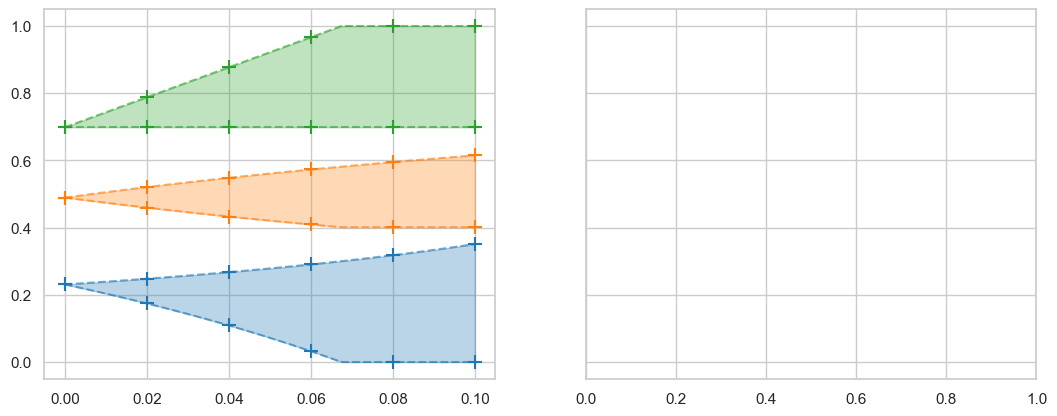

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize= (25.6/2,4.8 ))

range_curve = np.linspace(0,0.1,200)
range_ab = np.linspace(0,0.1,6)
for i,metric in enumerate(metrics):
    lower_results = []
    upper_results = []
    for val in range_curve:
        sens_results = prox_sens_fogliatio(prob_vec,alpha = val,group=0,disparity_metric = metric)
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])
    ax[0].fill_between(range_curve, lower_results, upper_results, alpha=.3,color = colours[i])
    ax[0].plot(range_curve, upper_results, ls='--', alpha=.6,color=colours[i])
    ax[0].plot(range_curve, lower_results, ls='--', alpha=.6,color=colours[i])
    
    lower_results = []
    upper_results = []

    for val in range_ab:
        sens_results = autobounds_prox_sens_fogliatio(prob_df,alpha = val,group=0,disparity_metric = metric)
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])

    ax[0].scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
    ax[0].scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])




In [ ]:
metrics = ["FPR","FNR","PPV"]
range_curve = np.linspace(0,0.1,200)
range_ab = np.linspace(0,0.1,8)
for i,metric in enumerate(metrics):
    lower_results = []
    upper_results = []

    for val in range_curve:
        sens_results = prox_sens_fogliatio(prob_vec,alpha = val,group=0,disparity_metric = metric,constrained=True)
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])
        
    if metric == "FNR":
        ax[1].plot(range_curve, lower_results, ls='--', alpha=.6,color=colours[i])
    else:
        ax[1].fill_between(range_curve, lower_results, upper_results, alpha=.3,color = colours[i])
        ax[1].plot(range_curve, upper_results, ls='--', alpha=.6,color=colours[i])
        ax[1].plot(range_curve, lower_results, ls='--', alpha=.6,color=colours[i])
    
    lower_results = []
    upper_results = []

    for val in range_ab:
        sens_results = autobounds_prox_sens_fogliatio(prob_df,alpha = val,group=0,disparity_metric = metric,dag_type="restriced")
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])

    ax[1].scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
    ax[1].scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

In [ ]:
range_ab

array([0.        , 0.01428571, 0.02857143, 0.04285714, 0.05714286,
       0.07142857, 0.08571429, 0.1       ])

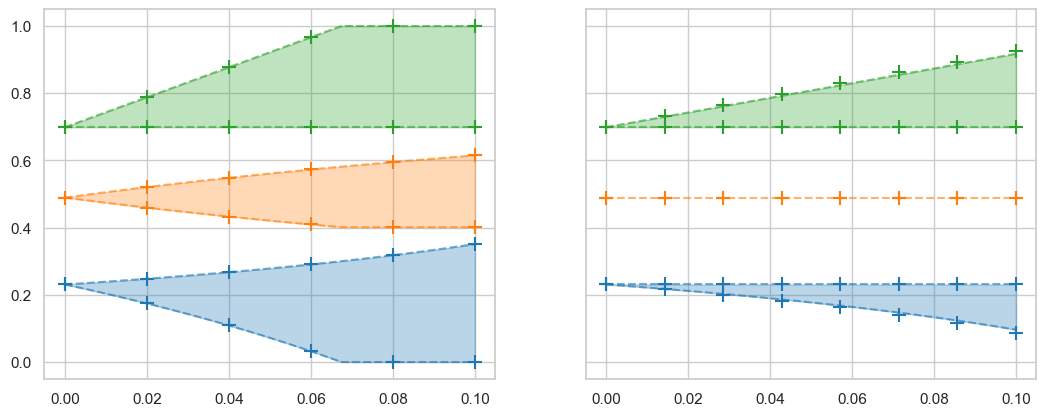

In [ ]:
fig

In [ ]:
legend_elements = [
                   Patch(facecolor=colours[0],
                         label='Color Patch'),
                     Patch(facecolor=colours[1],
                         label='Color Patch'),
                     Patch(facecolor=colours[2],
                         label='Color Patch'),
                         Line2D([0], [0], color='k', lw=2,ls="--", label='Line'),
                   Line2D([0], [0], marker='+', color='k', label='Scatter',
                          markerfacecolor='b', markersize=15),]
legend_titles = metrics +["Exact","Ours"]

In [ ]:
leg = ax[0].legend(legend_elements,legend_titles,loc="upper left",ncol=2,fontsize ="10")

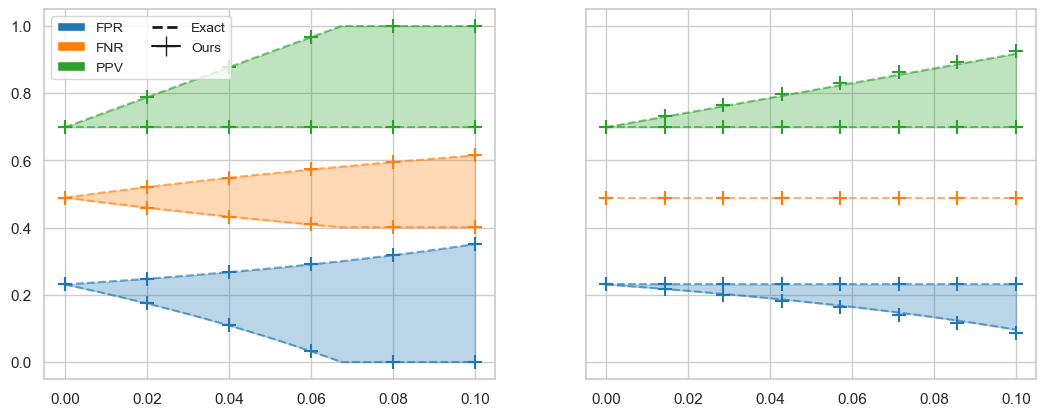

In [ ]:
fig

In [ ]:
alpha = 0.025
group=0
disparity_metric = "PPV"
optimiser="ipopt"
dag_type ="restricted"
op_group = 1 -group
proxy_equal = 1-alpha

dag = DAG()
# dag.from_structure("A -> Y, A->P, Y -> Z,P->Z")
if dag_type == "unrestricted":
    dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y, V->P, V -> Z,A->Z", unob = "U,V")
else:
    dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y,A->Z", unob = "U")
problem = causalProblem(dag)
problem.load_data(StringIO(prob_df.to_csv(index=False)))
numerator,denominator = get_numerator_denominator_fogliato(problem,metric=disparity_metric,group=group)
problem.set_estimand(numerator,div=denominator)
# problem.set_estimand(problem.query(f"Y=1&Z=0&A={group}&P=0"))
problem.add_constraint(problem.query("Y=0&Z=1"),symbol="==")
# problem.add_constraint(problem.query(f"Y=1&Z=0&A={op_group}"),symbol="==")
problem.add_constraint(problem.query(f"Y=1&Z=0&A={group}") - Query(alpha),symbol="<=")
program = problem.write_program()
result = program.run_pyomo('ipopt',verbose=False)
result

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

ValueError: Cannot load a SolverResults object with bad status: error

In [ ]:
M = pyo.ConcreteModel()
solver = pyo.SolverFactory('couenne')
for p in program.parameters:
    if p != 'objvar':
        setattr(M, p, pyo.Var(bounds = (0,1)))
    else:
        setattr(M, p, pyo.Var())
# Next loop is not elegant, needs refactoring
for i, c in enumerate(program.constraints):
    setattr(M, 'c' + str(i),
            pyo.Constraint(expr = 
                pyomo_symb[c[-1][0]](sum([ mult_params_pyomo(program.parameters, k, M ) for k in c[:-1] ]), 0)
            )
    )
program.M_upper = deepcopy(M)
program.M_lower = deepcopy(M)
program.M_upper.obj = pyo.Objective(expr = program.M_upper.objvar, sense = pyo.maximize)
program.M_lower.obj = pyo.Objective(expr = program.M_lower.objvar, sense = pyo.minimize)
solve1(solver,program.M_lower,'lower',True)
result = None

KeyboardInterrupt: 